# Sprint 6: Building a Country Classifier Bot with ResNet
Using the ResNet architecture and a dataset of labeled geolocation images, we train, validate, and test a model while exploring its predictions.

**Key Objectives:**
- Understand the dataset and preprocessing steps.
- Train a ResNet-based classifier on geolocation data.
- Evaluate the model and visualize its predictions.

## Dataset Overview
We are using a dataset of ~50,000 Google Street View images organized into folders by country. The dataset was split into:
- **Training set**: 70% of the images, used to train the model.
- **Validation set**: 15% of the images, used to tune hyperparameters and evaluate the model during training.
- **Test set**: 15% of the images, used to evaluate the final performance of the trained model.

The images were preprocessed to ensure consistent dimensions and normalization.

In [ ]:
# Importing libraries
import os
from torchvision import datasets, transforms

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to consistent dimensions
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Path to dataset
DATA_DIR = "./dataset/compressed_dataset"

# Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes

print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names[:10]}...")  # Show a few class names

## Model Architecture: ResNet
ResNet (Residual Network) is a widely used convolutional neural network (CNN) known for its ability to learn deep features effectively. We are using a pre-trained ResNet model (ResNet-18) and modifying its final layer to classify the images into countries.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

# Initialize model
model = resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # Adjust output layer

# Display model architecture
print(model)

## Training the Model
We train the ResNet model on the training dataset for a specified number of epochs. The training process involves:
1. **Forward Pass**: Feed images into the model to calculate predictions.
2. **Loss Calculation**: Compute the difference between predictions and actual labels using CrossEntropyLoss.
3. **Backward Pass**: Update model parameters to minimize the loss using the Adam optimizer.

We validate the model after each epoch to monitor its performance.

In [ ]:
# Import necessary libraries for training
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        inputs, labels = inputs.to("cpu"), labels.to("cpu")  # Use "cpu" for this demonstration

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(train_loader.dataset), 100 * correct / len(train_loader.dataset)

# Train for 1 epoch (for demonstration)
train_loss, train_acc = train_one_epoch(0)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

## Evaluating the Model
Once the model is trained, we evaluate it on the test dataset to measure its accuracy. We also visualize predictions on random test images.

In [ ]:
import matplotlib.pyplot as plt

# Evaluation on test data
def evaluate_and_visualize(model, test_loader, class_names):
    model.eval()
    images, labels = next(iter(test_loader))
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Plot predictions
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        image = images[i].permute(1, 2, 0).numpy()  # Convert to HWC format
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
        image = (image * 255).astype("uint8")
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
    plt.show()

# Run evaluation
test_loader = DataLoader(test_dataset, batch_size=4)
evaluate_and_visualize(model, test_loader, class_names)

## Challenges
- **Class Imbalance**: The dataset contains more images for certain countries, which may lead to biased predictions.
- **Resource Constraints**: Training deep learning models on a CPU is significantly slower than using GPUs.

## Next Steps
1. Experiment with data augmentation techniques to improve model generalization.
2. Implement techniques to handle class imbalance, such as oversampling or weighted loss.
3. Fine-tune the model on a smaller set of countries to reduce computational requirements.
4. Deploy the model and integrate it into the GeoGuessr bot for real-time predictions.

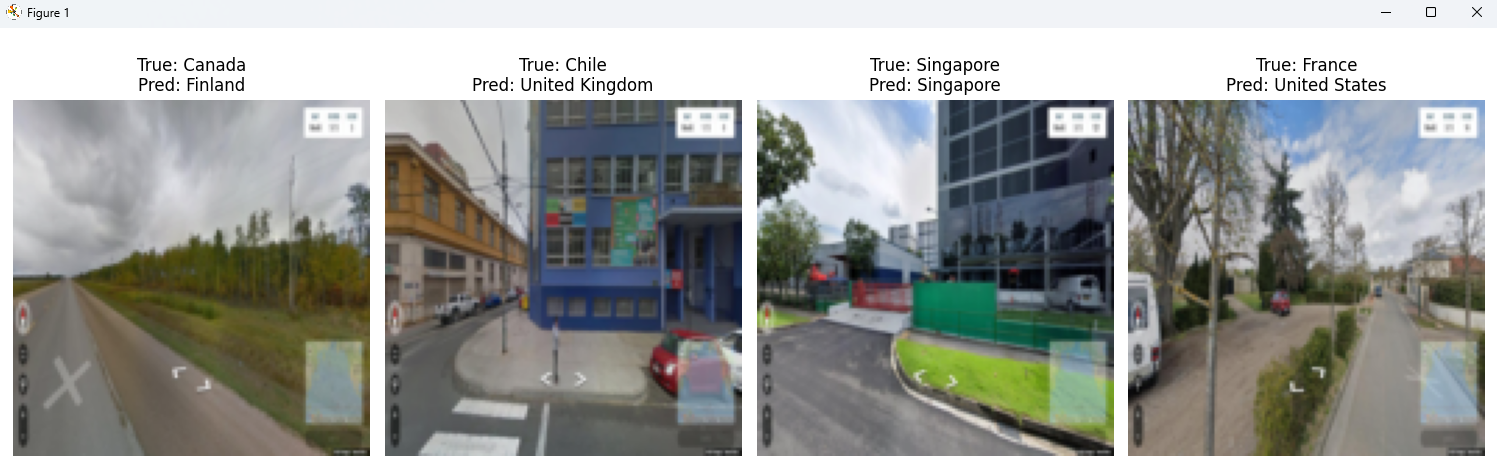